In [1]:
import arviz as az
import pandas as pd
import pymc as pm

# (1) Read data
df = pd.read_csv("../reports/figures/example_dataset.csv")
y_data = df[["A", "B", "C"]].values
X_data = df[["X"]].values.flatten()
n_obs = len(X_data)

compounds = ["A", "B", "C"]

coords = {
    "obs": range(n_obs),
    "compound": compounds,
}

with pm.Model(coords=coords) as model:
    # prior distribution for unobserved parameters
    L = pm.TruncatedNormal("L", mu=50, sigma=10, lower=0, dims="compound")
    k = pm.Normal("k", mu=0, sigma=0.2, dims="compound")
    X0 = pm.Normal("X0", mu=0, sigma=10, dims="compound")
    # prior distribution for unknown true X
    X_true = pm.Normal("X_true", mu=0, sigma=5, dims=("obs"))
    # Likelihood for X
    X = pm.Normal("X", mu=X_true, sigma=1.2, observed=X_data, dims=("obs"))
    # (2) This is our logistic model which is also the shape parameter a
    a = L/(1+pm.math.exp(-k*(X_true[:,None]-X0)))
    # Likelihood for y
    y = pm.Dirichlet("y", a=a, observed=y_data, dims=("obs","compound"))
    # (3) Run MCMC algorithm sample from posterior distribution
    trace = pm.sample()

# print summary of posterior samples
az.summary(trace,var_names=["L", "k", "X0"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L, k, X0, X_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
L[A],43.527,8.693,28.012,59.869,0.144,0.102,3488.0,2143.0,1.0
L[B],36.078,9.987,18.352,54.945,0.176,0.125,3093.0,2311.0,1.0
L[C],54.738,8.106,40.479,70.931,0.135,0.095,3547.0,2914.0,1.0
k[A],0.070,0.023,0.031,0.110,0.001,0.000,2564.0,2069.0,1.0
k[B],0.068,0.013,0.045,0.093,0.000,0.000,3242.0,2510.0,1.0
k[C],-0.238,0.020,-0.275,-0.200,0.000,0.000,3328.0,2753.0,1.0
X0[A],5.848,6.315,-5.521,17.994,0.108,0.076,3453.0,2002.0,1.0
X0[B],18.678,6.952,5.642,31.889,0.130,0.092,3127.0,2190.0,1.0
X0[C],-3.842,1.210,-6.084,-1.525,0.023,0.016,2796.0,2663.0,1.0


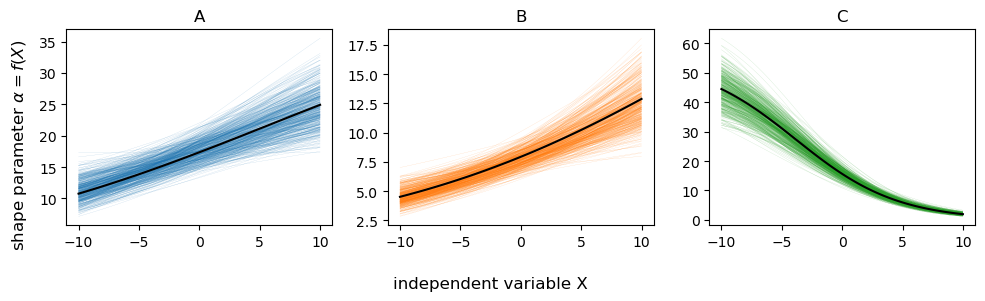

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# define the logistic function
def logistic_curve(x,L,k,x0):
    return L/(1+np.exp(-k*(x-x0)))

compounds = ["A", "B", "C"]

# we need a random number generator to draw random samples
# from the posterior distribution
rng = np.random.default_rng(1234)

# create a set of values for X
X_values = np.linspace(-10,10,100)
# extract posterior from trace (and stack chains)
posterior = trace.posterior.stack(samples=("chain","draw"))

N_TOTAL = len(posterior["L"].sel(compound="A"))

fig, ax = plt.subplots(1,3, figsize=(10,3), sharex=True)

# draw 500 samples from the posterior distribution as thin lines 
for n in rng.choice(range(N_TOTAL), size=500):
    L_p  = posterior["L"].isel(samples=n).values
    k_p  = posterior["k"].isel(samples=n).values
    X0_p = posterior["X0"].isel(samples=n).values
    for i in range(3):
        ax[i].plot(X_values,logistic_curve(X_values,L_p[i],k_p[i],X0_p[i]), lw=0.1, alpha=0.5, c=f'C{i}')

# extract mean parameter values
L_p_mean  = posterior["L"].mean("samples").values
k_p_mean  = posterior["k"].mean("samples").values
X0_p_mean = posterior["X0"].mean("samples").values
# and plot on top as black line
for i in range(3):
    ax[i].plot(X_values,logistic_curve(X_values,L_p_mean[i],k_p_mean[i],X0_p_mean[i]), 'k-')
    ax[i].set_title(compounds[i])

fig.supxlabel("independent variable X")
fig.supylabel(r"shape parameter $\alpha = f(X)$")

fig.tight_layout()
fig.savefig(f"../reports/figures/minimal_inference_example_alphas.png",dpi=300,bbox_inches='tight', pad_inches = 0.01)

In [57]:
# sample from posterior predicitive distribution for y (= {A, B, C}).
with model:
    trace.extend(pm.sample_posterior_predictive(trace))

Sampling: [X, y]


Output()

(150, 3)
(150, 3)


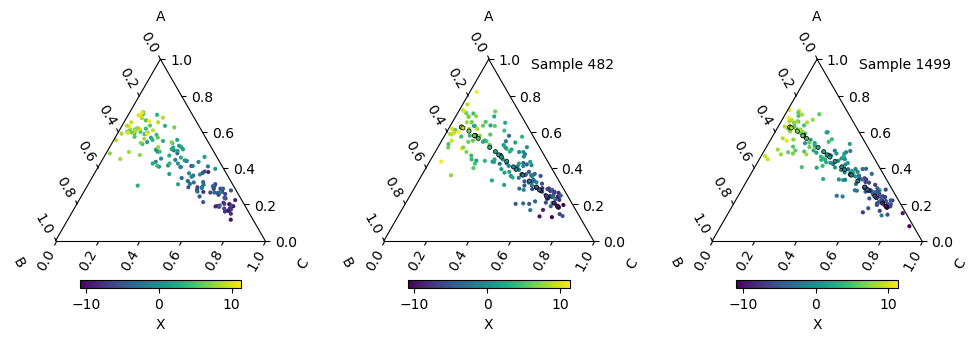

In [65]:
import mpltern

posterior_predictive = trace.posterior_predictive.stack(samples=("chain","draw"))
# mean of posterior pred.
y_pred_mean = posterior_predictive["y"].mean("samples")
X_pred_mean = posterior_predictive["X"].mean("samples")

# Let's plot the actual data plus two random samples for the y posterior pred.
N_pp = 2
fig, ax = plt.subplots(1,1+N_pp,subplot_kw={"projection": "ternary"},figsize=(10,3.5))

vmin = min(X_data)
vmax = max(X_data)
pc = ax[0].scatter(y_data[:,0], y_data[:,1], y_data[:,2], c=X_data, vmin=vmin, vmax=vmax, marker='.', lw=0)

for i,s in enumerate(rng.choice(len(posterior_predictive.samples),2)):
    y_pred = posterior_predictive["y"].isel(samples=s)
    X_pred = posterior_predictive["X"].isel(samples=s)
    print(y_pred.shape)
    pc = ax[1+i].scatter(y_pred[:,0], y_pred[:,1], y_pred[:,2], c=X_pred, vmin=vmin, vmax=vmax, marker='.',lw=0)
    inc = 5
    ax[1+i].scatter(y_pred_mean[::inc,0], y_pred_mean[::inc,1], y_pred_mean[::inc,2], c=X_pred_mean[::inc], vmin=vmin, vmax=vmax, marker='.',lw=0.5, edgecolors='k')
    ax[1+i].text(0.7,0.95,f"Sample {s}",transform=ax[1+i].transAxes)

for a in ax:
    plt.colorbar(pc,ax=a,orientation="horizontal", shrink=0.7,label='X')
    a.set_tlabel('A')
    a.set_llabel('B')
    a.set_rlabel('C')

fig.tight_layout()
fig.savefig(f"../reports/figures/minimal_inference_example_ternary_with_pp.png",dpi=300,bbox_inches='tight', pad_inches = 0.01)

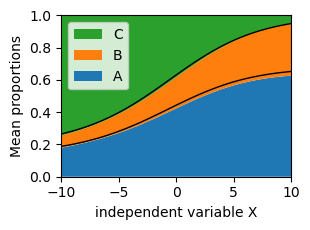

In [116]:
fig, ax = plt.subplots(1,1,figsize=(3.2, 2.4))

true_X0 = np.array([-29, 31, -6.4])
true_L = np.array([ 20,  22, 90])
true_k = np.array([0.08, 0.02, -0.25])

true_a = logistic_curve(X_values[:,None],true_L,true_k,true_X0)
true_a /= true_a.sum(axis=1)[:,None]
true_boundaries = np.cumsum(true_a,axis=1)

this_a = logistic_curve(X_values[:,None],L_p_mean,k_p_mean,X0_p_mean)
this_a /= this_a.sum(axis=1)[:,None]

ax.stackplot(X_values,this_a.T,labels=compounds)
ax.plot(X_values,true_boundaries[:,:-1],'k-',lw=1)
ax.set_xlabel("independent variable X")
ax.set_ylabel("Mean proportions")
ax.legend(loc=2, reverse=True)
ax.set_xlim(-10,10)
ax.set_ylim(0,1)

fig.tight_layout()
fig.savefig(f"../reports/figures/minimal_inference_example_mean_proportions.png",dpi=300,bbox_inches='tight', pad_inches = 0.01)